### Setup and Data Downloading

In [1]:
# Command: pip install matplotlib Pillow tensorflow tf-keras-vis numpy scipy

import os
import glob
import shutil
import random
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread

import collections
import collections.abc
collections.Iterable = collections.abc.Iterable

import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tf_keras_vis.utils.scores import CategoricalScore
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

from vis.utils import utils
from tf_keras_vis.utils import normalize
from tf_keras_vis.saliency import Saliency

### Loading and Processing Data

In [ ]:
dataset_zip = Path('data/binary_classification/train.zip')
images_base = dataset_zip.parent / 'images'
shutil.unpack_archive(dataset_zip, images_base)

cat_files = glob.glob(str(images_base / 'train/cat*.jpg'))
dog_files = glob.glob(str(images_base / 'train/dog*.jpg'))

for folder in ['train/cat', 'train/dog', 'test/cat', 'test/dog']:
    path = images_base / folder
    path.mkdir(parents=True, exist_ok=True)

train_dog_files = random.sample(dog_files, 1000)
train_cat_files = random.sample(cat_files, 1000)

test_dog_files = [f for f in random.sample(dog_files, 100) if f not in train_dog_files]
test_cat_files = [f for f in random.sample(cat_files, 100) if f not in train_cat_files]

for f in train_dog_files:
    shutil.move(f, images_base / 'train/dog')

for f in train_cat_files:
    shutil.move(f, images_base / 'train/cat')

for f in test_dog_files:
    shutil.move(f, images_base / 'test/dog')

for f in test_cat_files:
    shutil.move(f, images_base / 'test/cat')

print(f'Total training dog images: {len(os.listdir(images_base / 'train/dog'))}')
print(f'Total training cat images: {len(os.listdir(images_base / 'train/cat'))}')
print(f'Total test dog images: {len(os.listdir(images_base / 'test/dog'))}')
print(f'Total test cat images: {len(os.listdir(images_base / 'test/cat'))}')

In [4]:
training_dir = r'C:\Users\joaov_zm1q2wh\python\etsai\week_5\code\data\binary_classification\images\train'
testing_dir =  r'C:\Users\joaov_zm1q2wh\python\etsai\week_5\code\data\binary_classification\images\test'

### Train Model

In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1./255.,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)
validation_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=(300, 300),
    batch_size=128,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
        testing_dir,
        target_size=(300, 300),
        batch_size=32,
        class_mode='binary'
)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

history = model.fit(
    train_generator,
    epochs=100,
    verbose=1,
    validation_data = validation_generator
)

In [10]:
# Recuperar histórico de treino
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
epochs = range(len(acc))

# Acurácia
plt.figure(figsize=(10,5))
plt.plot(epochs, acc, 'b', label='Acurácia de Treinamento')
plt.plot(epochs, val_acc, 'r', label='Acurácia de Validação')
plt.title('Acurácia por Época')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

# Perda
plt.figure(figsize=(10,5))
plt.plot(epochs, loss, 'b', label='Perda de Treinamento')
plt.plot(epochs, val_loss, 'r', label='Perda de Validação')
plt.title('Perda por Época')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.show()

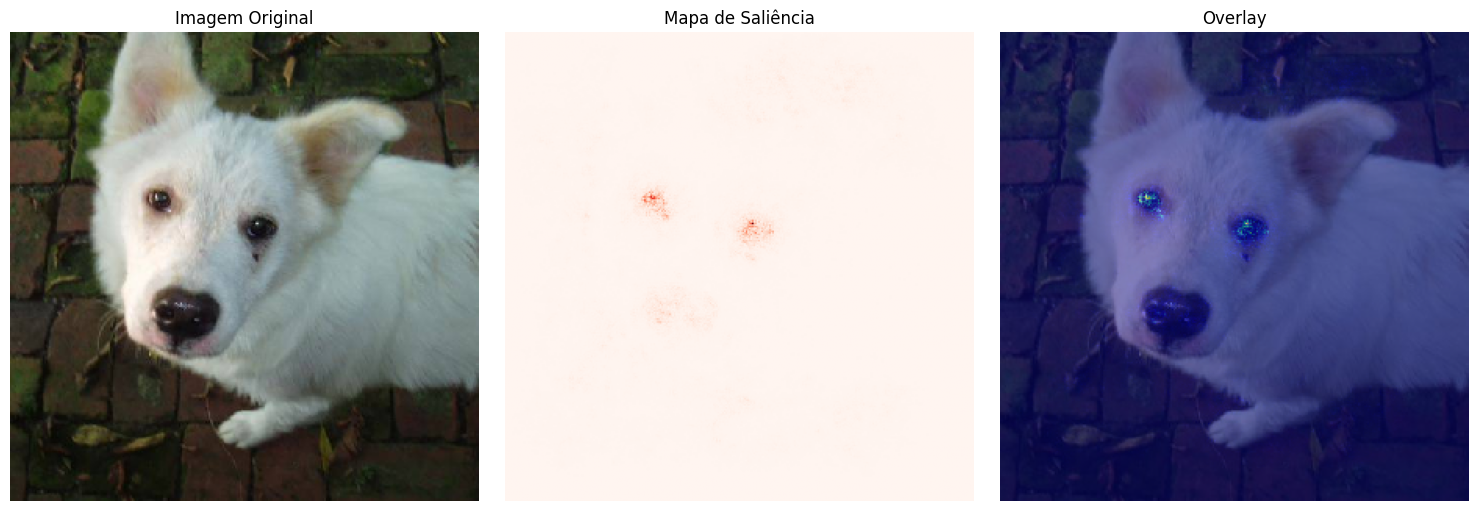

In [18]:
testing_dir_dog = r'C:\Users\joaov_zm1q2wh\python\etsai\week_5\code\data\images\test\dog'

# random_image = random.sample(os.listdir(testing_dir_dog), 1)[0]
# img_path = os.path.join(testing_dir_dog, random_image)
specific_image = 'dog.11674.jpg'
img_path = os.path.join(testing_dir_dog, specific_image)

img = tf.keras.preprocessing.image.load_img(img_path, target_size=(300, 300))

x = img_to_array(img)
x = x.reshape((1,) + x.shape)

# Ajustar modelo e gerar mapa de saliência (trocar a última camada pela camada linear)
layer_idx = utils.find_layer_idx(model, model.layers[-1].name)
model.layers[-1].activation = tf.keras.activations.linear
model = utils.apply_modifications(model)

score = CategoricalScore([0])
saliency = Saliency(model, clone=False)

saliency_map = saliency(score, x)
saliency_map = normalize(saliency_map)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(img)
ax[0].set_title("Imagem Original")
ax[0].axis('off')

ax[1].imshow(saliency_map[0], cmap='Reds')
ax[1].set_title("Mapa de Saliência")
ax[1].axis('off')

ax[2].imshow(img)
ax[2].imshow(saliency_map[0], cmap='jet', alpha=0.5)
ax[2].set_title("Overlay")
ax[2].axis('off')

plt.tight_layout()
plt.show()

Se reparar bem, a cada execução o mapa muda. O motivo de o mapa de saliência está nos dois parâmetros <code>smooth_samples</code> e <code>smooth_noise</code>.

Esses parâmetros ativam o método conhecido como <b>SmoothGrad</b> (uma técnica para suavizar os mapas de saliência), que funciona adicionando ruído aleatório à imagem várias vezes e tirando a média dos gradientes resultantes.

Nesse caso, a cada execução:

- São geradas 20 cópias da imagem com ruido (smooth_samples=20)
- Cada cópia recebe um ruído diferente (smooth_noise=0.2 define a intensidade)
- Calcula o gradiente de cada uma
- Faz a média para reduzir o ruído visual e realçar as áreas mais estáveis de atenção

Como o ruído é aleatório, o resultado muda levemente toda vez, mas a essência da imagem se mantém.

Podemos fixar a seed, por exemplo adicionando isso antes de gerar o mapa:

```python
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)
```

Também é possível gerar mapas determinísticos, usando o gradiente puro:

```python
saliency_map = saliency(score, x)
```



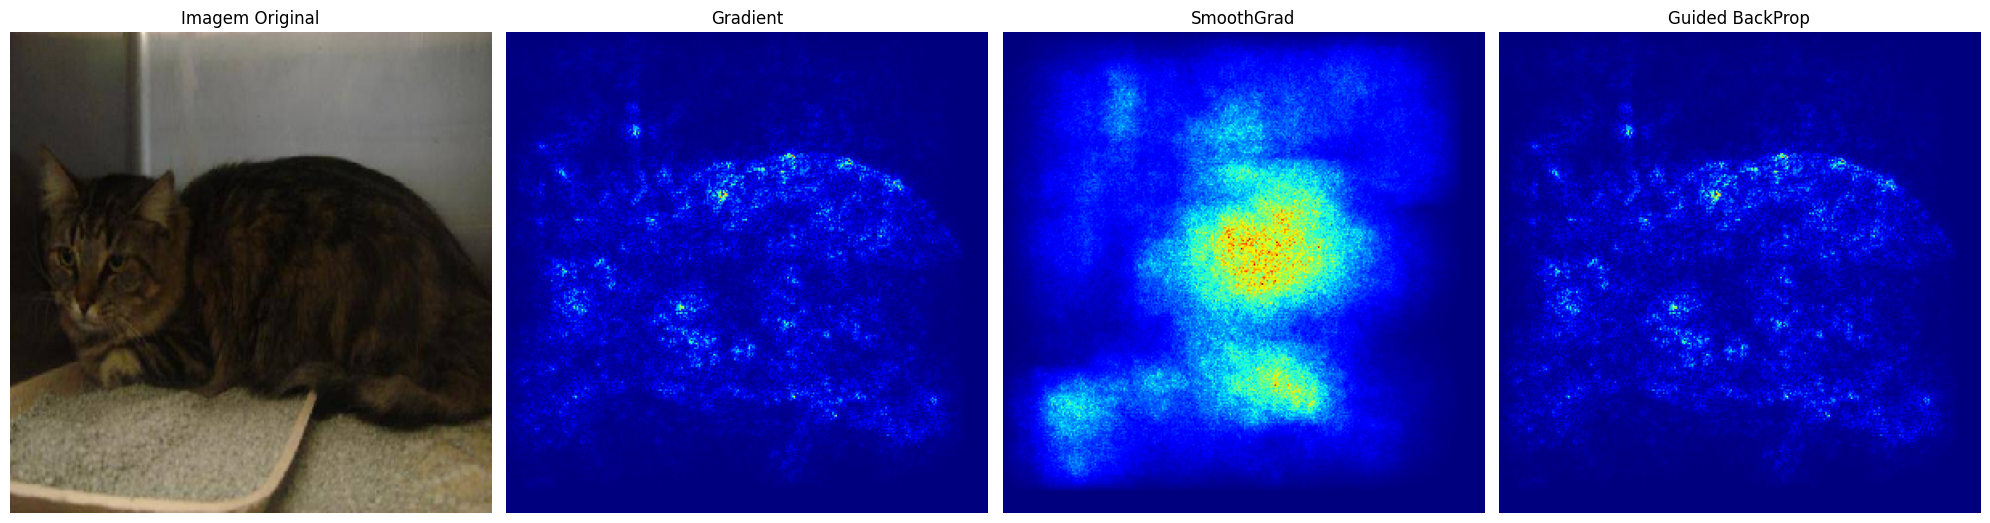

In [21]:
### ANTES
testing_dir_dog = r'C:\Users\joaov_zm1q2wh\python\etsai\week_5\code\data\images\test\cat'
specific_image = 'cat.11966.jpg'
img_path = os.path.join(testing_dir_dog, specific_image)
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(300, 300))
x = img_to_array(img)
x = x.reshape((1,) + x.shape)

layer_idx = utils.find_layer_idx(model, model.layers[-1].name)
model.layers[-1].activation = tf.keras.activations.linear
model = utils.apply_modifications(model)

np.random.seed(42)
tf.random.set_seed(42)

score = CategoricalScore(0)

# Gradient
saliency_grad = Saliency(model, clone=False)
saliency_map_grad = saliency_grad(score, x)
saliency_map_grad = normalize(saliency_map_grad)

# SmoothGrad
saliency_smooth = Saliency(model, clone=False)
saliency_map_smooth = saliency_smooth(score, x, smooth_samples=20, smooth_noise=0.20)
saliency_map_smooth = normalize(saliency_map_smooth)

# Guided Backprop
saliency_guided = Saliency(model, clone=False, model_modifier=None)
saliency_map_guided = saliency_guided(score, x)
saliency_map_guided = normalize(saliency_map_guided)

fig, axs = plt.subplots(1, 4, figsize=(20, 7))

axs[0].imshow(img)
axs[0].set_title('Imagem Original')
axs[0].axis('off')

axs[1].imshow(saliency_map_grad[0], cmap='jet')
axs[1].set_title('Gradient')
axs[1].axis('off')

axs[2].imshow(saliency_map_smooth[0], cmap='jet')
axs[2].set_title('SmoothGrad')
axs[2].axis('off')

axs[3].imshow(saliency_map_guided[0], cmap='jet')
axs[3].set_title('Guided BackProp')
axs[3].axis('off')

plt.tight_layout()
plt.show()

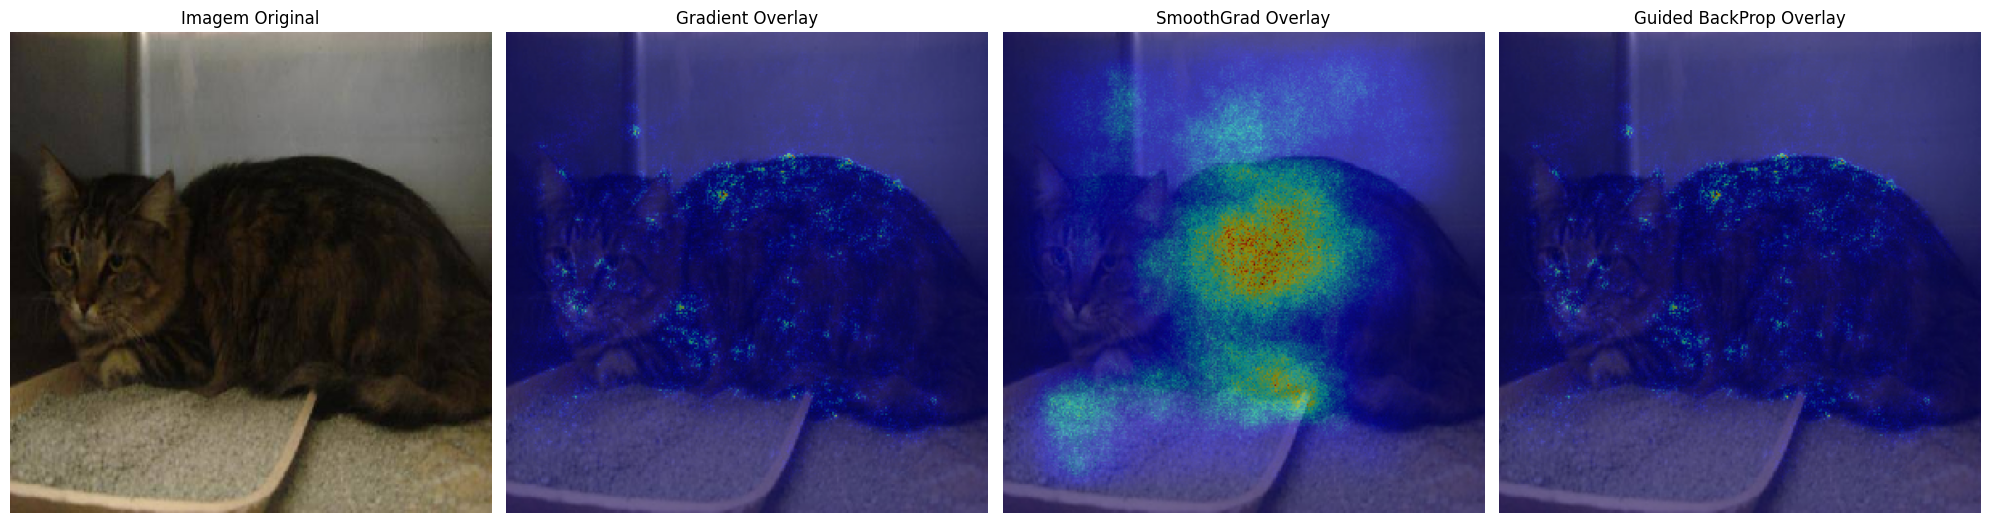

In [30]:
import cv2

def overlay_saliency(img, saliency_map, alpha=0.5, cmap='jet'):
    saliency_norm = np.uint8(255 * saliency_map[0])
    saliency_color = cv2.applyColorMap(saliency_norm, cv2.COLORMAP_JET)
    saliency_color = cv2.cvtColor(saliency_color, cv2.COLOR_BGR2RGB)
    
    if img.mode != 'RGB':
        img = img.convert('RGB')
    img_array = np.array(img)
    
    overlayed = cv2.addWeighted(img_array, 1-alpha, saliency_color, alpha, 0)
    return overlayed

fig, axs = plt.subplots(1, 4, figsize=(20, 7))

axs[0].imshow(img)
axs[0].set_title('Imagem Original')
axs[0].axis('off')

axs[1].imshow(overlay_saliency(img, saliency_map_grad))
axs[1].set_title('Gradient Overlay')
axs[1].axis('off')

axs[2].imshow(overlay_saliency(img, saliency_map_smooth))
axs[2].set_title('SmoothGrad Overlay')
axs[2].axis('off')

axs[3].imshow(overlay_saliency(img, saliency_map_guided))
axs[3].set_title('Guided BackProp Overlay')
axs[3].axis('off')

plt.tight_layout()
plt.show()

### Análise da Comparação:

Gradient: Este mapa é o mais "ruidoso". Ele mostra todas as áreas que qualquer influência (positiva ou negativa) na decisão, resultando em um mapa difuso.

SmoothGrad: A média de gradientes com ruído limpa o mapa significativamente, focando melhor nas áreas que consistentemente contribuem para a decisão.

Guided BackProp: Este método é visualmente o mais nítido. Ele modifica a retropropagação para mostrar apenas as características que têm uma influência positiva na ativação da classe. O resultado é um mapa muito focado nos contornos e texturas exatos que o modelo usou para identificar a classe.